In [1]:
import os
import sys
import time
import glob
import io
import pytesseract
from pytesseract import Output
from PIL import Image, ImageDraw
import cv2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import layoutparser

In [2]:
nb_dir = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src'
sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

import config
import src.utilities.app_context as app_context
from src.utilities.primalaynet.infer import draw_box
app_context.init()
app_context.application_context = dict({'task_id': 'BM-DUMMY'})

#path to craft model, weight can be pulled form the production bracnh of repo
config.CRAFT_MODEL_PATH = "/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_mlt_25k.pth"
config.CRAFT_REFINE_MODEL_PATH  = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_refiner_CTW1500.pth' 


from src.services.main import generate_response,break_blocks,merge_vertically,merge_horizontally,extract_images_and_text_regions

/home/dhiraj/py_envs/bm/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


[2021-05-25 12:30:41,550] {geos.py:73} MainThread DEBUG in geos: Found GEOS DLL: <CDLL '/home/dhiraj/py_envs/bm/lib/python3.6/site-packages/shapely/.libs/libgeos_c-a68605fd.so.1.13.1', handle 67556f0 at 0x7f46c28f2358>, using it.
[2021-05-25 12:30:41,576] {geos.py:38} MainThread DEBUG in geos: Trying `CDLL(libc.so.6)`
[2021-05-25 12:30:41,579] {geos.py:55} MainThread DEBUG in geos: Library path: 'libc.so.6'
[2021-05-25 12:30:41,581] {geos.py:56} MainThread DEBUG in geos: DLL: <CDLL 'libc.so.6', handle 7f475f02c000 at 0x7f46c28f25c0>
Loading weights of refiner from checkpoint (./model/craft_refiner_CTW1500.pth)


In [3]:
import layoutparser as lp
model_primalaynet = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',label_map = {1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"},extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5])


In [4]:
def draw_box(filepath,desired_width, desired_height,save_dir, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    if type(df) is list:
        for i in df:
            for index, row in i.iterrows():
                left   = int(row['text_left'])
                right  = int(row['text_width'] + left)
                top    = int(row['text_top'])
                bottom = int(row["text_height"] + top)
                draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    else:

        for index, row in df.iterrows():
            left   = int(row['text_left'])
            right  = int(row['text_width'] + left)
            top    = int(row['text_top'])
            bottom = int(row["text_height"] + top)
            draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    save_filepath = os.path.join(save_dir, os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

In [5]:
#dir which contains the pdf file
input_dir = '/home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/'
#filename = 'footer_test.pdf'
#filename  = 'grade7-review2timetable.pdf'
#filename = '20695.pdf'
#filename = 's2_en.pdf'
#filename = 'scan_1.pdf'
#filename = 'ncert.pdf'
#filename = 'p_df_error.pdf'
#filename  = 'test_table.pdf'
#filename  = 'NDEAR.pdf'
filename   = 'font_issue.pdf'

lang     = 'en'

In [6]:
[pdf_data,flags] = extract_images_and_text_regions(filename, input_dir,lang,page_layout='single_column')
[pdf_data,flags] = merge_horizontally([pdf_data,flags])
[pdf_data,flags] = merge_vertically([pdf_data,flags])
[pdf_data,flags] = break_blocks([pdf_data,flags])
response        = generate_response([pdf_data,flags])

[2021-05-25 12:30:46,303] {loghandler.py:21} MainThread INFO in loghandler: document preprocessing started ===>
[2021-05-25 12:30:46,305] {loghandler.py:21} MainThread INFO in loghandler: created processing directories successfully /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/font_issue_edecc9b2-bd26-11eb-9799-d15bdd9704c8
[2021-05-25 12:30:46,309] {loghandler.py:21} MainThread INFO in loghandler: filepath /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/font_issue.pdf, working_dir /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/font_issue_edecc9b2-bd26-11eb-9799-d15bdd9704c8
[2021-05-25 12:30:47,277] {loghandler.py:21} MainThread INFO in loghandler: Extracting xml of /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/font_issue.pd

In [8]:
flags

{'doc_class': 'class_1', 'page_layout': 'double_column'}

In [9]:
# width_ratio = pdf_data['page_width'] / pdf_data['pdf_image_width']
# height_ratio = pdf_data['page_height'] / pdf_data['pdf_image_height']
# predict_primanet(img_filepath,pdf_bg_img_filepaths,to_check[0],width_ratio,height_ratio)

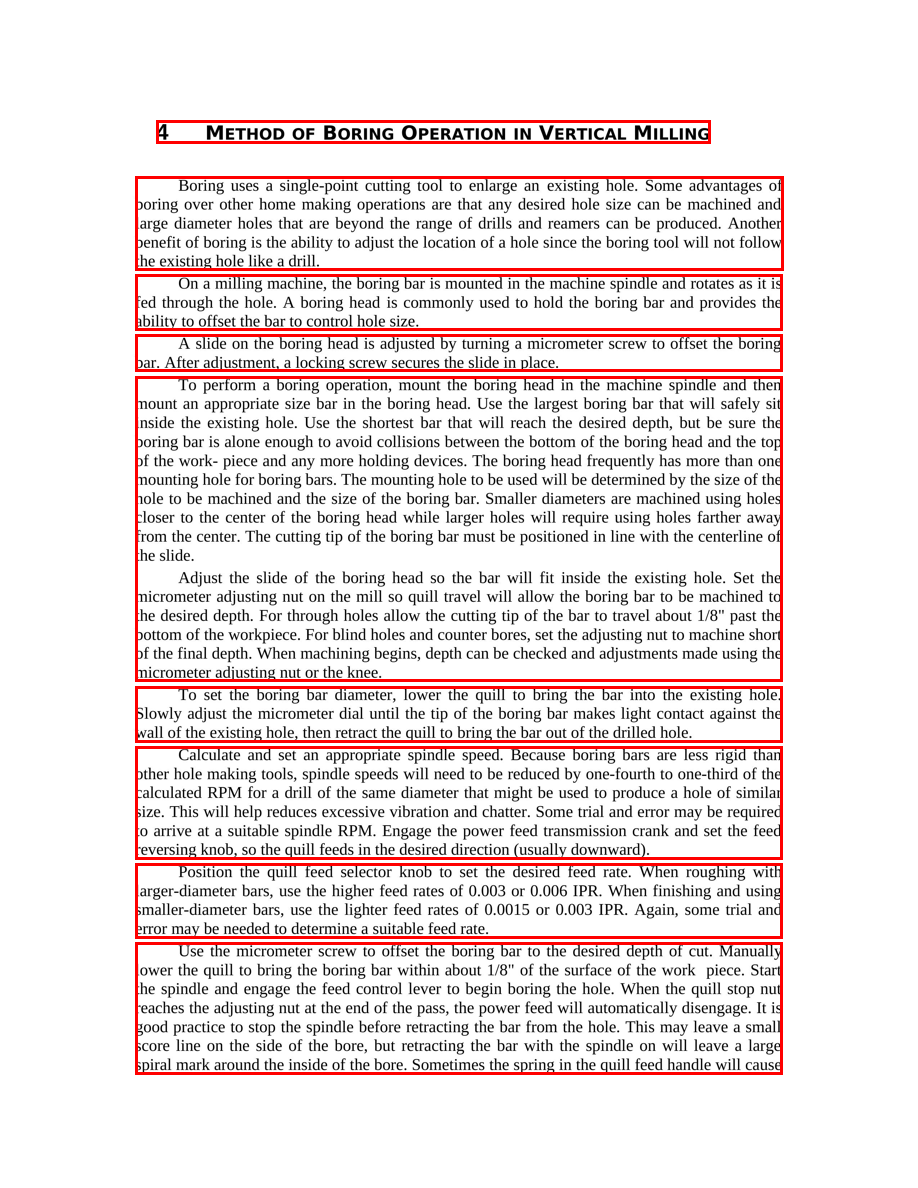

In [12]:
page_index = 0
to_check        = pdf_data['p_dfs']
#to_check_in_df        = pdf_data['v_dfs'][page_index]
img_filepath    = pdf_data['pdf_image_paths'][page_index]
pdf_bg_img_filepaths  = pdf_data['pdf_bg_img_filepaths'][page_index]
df              = to_check[page_index]

desired_width, desired_height = pdf_data['page_width'] , pdf_data['page_height']
draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)

In [13]:
df

,index,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib,font_family_updated,font_size_updated,children,avg_line_height,level_0
0,0,0,120,156,554,23,4 M ETHOD OF B ORING O PERATION IN V ERTICA...,15,CAAAAA+DejaVuSans,#000000,BOLD,DejaVuSans,15,None,23,NaN
1,NaN,13,176,135,648,94,Boring uses a single-point cutting tool to en...,16,DAAAAA+LiberationSerif,#000000,,LiberationSerif,16,"{""level_0"":{""0"":1,""1"":2,""2"":3,""3"":4,""4"":5},""in...",18,NaN
2,NaN,19,274,135,647,56,"On a milling machine, the boring bar is mount...",16,DAAAAA+LiberationSerif,#000000,,LiberationSerif,16,"{""level_0"":{""5"":6,""6"":7,""7"":8},""index"":{""5"":6,...",18,NaN
3,NaN,24,334,135,647,37,A slide on the boring head is adjusted by tur...,16,DAAAAA+LiberationSerif,#000000,,LiberationSerif,16,"{""level_0"":{""8"":9,""9"":10},""index"":{""8"":9,""9"":1...",18,NaN
4,NaN,27,376,135,647,305,"To perform a boring operation, mount the bori...",16,DAAAAA+LiberationSerif,#000000,,LiberationSerif,16,"{""level_0"":{""10"":11,""11"":12,""12"":13,""13"":14,""1...",19,NaN
5,NaN,44,686,135,647,56,"To set the boring bar diameter, lower the qui...",16,DAAAAA+LiberationSerif,#000000,,LiberationSerif,16,"{""level_0"":{""25"":26,""26"":27,""27"":28},""index"":{...",18,NaN
6,NaN,48,746,135,647,113,Calculate and set an appropriate spindle spee...,16,DAAAAA+LiberationSerif,#000000,,LiberationSerif,16,"{""level_0"":{""28"":29,""29"":30,""30"":31,""31"":32,""3...",18,NaN
7,NaN,54,863,135,647,75,Position the quill feed selector knob to set ...,16,DAAAAA+LiberationSerif,#000000,,LiberationSerif,16,"{""level_0"":{""34"":35,""35"":36,""36"":37,""37"":38},""...",18,NaN
8,NaN,58,942,135,647,132,Use the micrometer screw to offset the boring...,16,DAAAAA+LiberationSerif,#000000,,LiberationSerif,16,"{""level_0"":{""38"":39,""39"":40,""40"":41,""41"":42,""4...",18,NaN


In [ ]:
for i in to_check_in_df['children']:
    d =pd.read_json(i)
    print(d)
    print(d['children'])

In [ ]:
import numpy as np
p_df_image = draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)
sc_pdf_image = draw_box(img_filepath,desired_width, desired_height, 'path',to_check_in_df, color="red", save=False)
stiched_imag = np.hstack([np.array(p_df_image) ,np.array(sc_pdf_image)])
compare_image = Image.fromarray(stiched_imag)
compare_image.save("/home/naresh/1.jpg")

In [ ]:
def predict_primanet(image_path,bg_image_path,in_df,width_ratio,height_ratio):
    image1  = cv2.imread(image_path)
    image2  = cv2.imread(bg_image_path)
    image = image1[..., ::-1] 
    layout = model_primalaynet.detect(image)
    boxes,coords = draw_box(layout, in_df,width_ratio,height_ratio)
    final_coord= []
    for coord in coords:
        temp_dict={}
        temp_dict['text_left']=coord[0]; temp_dict['text_top']=coord[1]
        temp_dict['text_width']=coord[2]; temp_dict['text_height']=coord[3]
        #draw.rectangle(coord, width=3,outline='red')
        final_coord.append(temp_dict)
        cv2.rectangle(image1, (int(coord[0]),int(coord[1])), (int(coord[2]),int(coord[3])),(255,255,0),3)
        cv2.rectangle(image2, (int(coord[0]*width_ratio),int(coord[1]*height_ratio)), (int(coord[2]*width_ratio),int(coord[3]*height_ratio)),(255,255,0),3)

        cv2.imwrite("1.jpg",image1)
        cv2.imwrite("2.jpg",image2)

    return final_coord

In [ ]:
response

In [ ]:
p